In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier

from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, f1_score, log_loss, accuracy_score, precision_score,recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from keras import Input, ops, layers, Model
from scikeras.wrappers import KerasClassifier
import joblib

sns.set_theme("notebook")


___

# Necessary EDA

In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# customerID is a series of non-helpful anonymous id structure that will make things
# more confusing if I decided to use it as my index inplace of integer values. So I will drop it
df.drop("customerID", axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Senior Citizen came in as Binary meaning numeric, to make sure we don't miss it
# we can just add to category list
object_cols = df.select_dtypes(include=['object']).columns.tolist()
category_list = object_cols + ['SeniorCitizen']
# Turns our category columns into the Dtype category
for col in category_list:
    df[col] = pd.Categorical(df[col])


integer_col = df.select_dtypes(include=['int64']).columns.tolist()
float_col = df.select_dtypes(include=['float64']).columns.tolist()

# Using very helpful downcast parameter that will take our numerical value and downcast it to the number of bits that can still represent our data
for col in integer_col:
    df[col] = pd.to_numeric(df[col], downcast='integer')

for col in float_col:
    df[col] = pd.to_numeric(df[col], downcast='float')

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

___

# Data Preprocessing

In [3]:
X = df.drop("Churn", axis=1).copy()
y = df["Churn"].copy()

In [4]:
category_col = X.select_dtypes(include= "category").columns.tolist()
numerical_cols = X.select_dtypes(include="number").columns.tolist()

preprocessor = ColumnTransformer(transformers=[('numeric',StandardScaler(), numerical_cols), ("categorical", OneHotEncoder(), category_col)])

x_scaled = preprocessor.fit_transform(X)

X = pd.DataFrame(x_scaled, columns = preprocessor.get_feature_names_out())


In [5]:
y_ohe = pd.get_dummies(y) # One Hot encoded

In [6]:
y = y.cat.codes

In [7]:
joblib.dump(preprocessor, "scaler.pkl")

['scaler.pkl']

**Note:** This is the process of separating our data between the target variable and the rest of our variables. In this step we also turned our categorical variables into there numerical counterparts. We went ahead with **One Hot Encoding** vs **Label Encoding** of our variables because we do not want the model to assume order between our variables. We also went ahead and **Standardized** our numbers into z-score standardization for some of our models that needed them. Although not all of them need such as our Random Forest since we need it for other models especially our logistic regression we went and standardized all the measurements. (For this project I did not need to one-hot-encode the y to get y_ohe since its a binary classification but I have it here just in case)

___
# Modeling

In [8]:

# Grab best parameters create a new model where we will do a test and get ROC curve then explain those
def grid_cv(X, y, clf, paramgrid ,cv = 10, shuffle = True, random_state = 42 , n_jobs = -1):
    """
     Perform cross validation using GridSearchCV to fine tune hyperparameters

    Parameters
    ----------
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix.
    y : pandas.Series or numpy.ndarray
        Labels.
    clf : sklearn-like estimator
        Classifier implementing fit/predict
    cv : int
        Number of folds (default 10).
    shuffle : bool
        Shuffle before splitting (default True).
    random_state : int
        RNG seed for shuffling (default 42).
    paramgrid: dict [str, list] {  param_name : param_values }
        Param_name a str representing the name of the parameter to optimize.
        param_values a list of values to be tested for corresponding parameter
    n_jobs: int (default -1)
        Number of jobs to run in parallel.
    Returns
    -------
    dict
        {
            'best_estimator': fitted model with best f1_macro,
            'best_params': best hyperparameters,
            'best_f1_macro': best f1_macro score,
            'best_accuracy': accuracy corresponding to best f1_macro,
            'cv_results': full cross-validation results
        }
    """
    kfold = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    grid = GridSearchCV(clf, param_grid=paramgrid, cv=kfold, scoring=["accuracy", "f1_macro"], refit="f1_macro", n_jobs=n_jobs)
    grid.fit(X, y)
    best_model = grid.best_estimator_

    return {
        'best_model': best_model, # Best model object
        'best_params': grid.best_params_,
        'best_f1_macro': grid.best_score_,
        'cv_results': grid.cv_results_,
        }

    # grid.best_score the best f1_macro
    # grid.best_params dict of name of parameter and value
    # grid.best_estimator_ the actual model object I can use

# Its probably more important to detect churn vs not churn so minimizing the number of False Negative would our main approach
# True positive = The customer was predicted to churn and did churn
# True negative = The customer was predicted to not churn and did not churn
# False positive = The customer was predicted to Churn and did not churn
# False negative = The customer was predicted to not churn and did churn - Probably want to minimize this

# result[0] grab the best estimator model

# maybe want to use precision according to the imbalance in my data.

In [9]:
# Before calling make sure to create a new model with optimized parameters
def kfold_cv(clf, X, y , cv = 10, random_state = 42):
    """
    Perform stratified K-fold cross-validation and return out-of-fold predictions.
    Parameters
    ----------
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix.
    y : pandas.Series or numpy.ndarray
        Labels.
    clf : sklearn-like estimator
        Classifier implementing fit/predict (optionally predict_proba/decision_function).
    cv : int
        Number of folds (default 10)
    random_state : int
        RNG seed for shuffling (default 42).

    Returns
    -------
    (pandas.DataFrame
        DataFrame aligned with input order containing:
        - fold: which fold each sample served as validation
        - y_true: true label
        - y_pred: out-of-fold predicted class
        - y_proba: probability for the positive class (if available), else NaN
    ,
    pandas.DataFrame
        Dataframe containing the metrics for each fold:
        - accuracy: accuracy score
        - precision: precision score
        - recall: recall score
        - f1: F1 score (if available)
    )
    """

    oof_records = []
    fold_metrics_list = []
    current_fold = 0
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for train_index, test_index in kfold.split(X, y):
        current_fold += 1
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_proba = clf.predict_proba(X_test)[:,1]

        oof_fold = pd.DataFrame({
            "fold": current_fold,
            "y_true": y_test,
            "y_pred": y_pred,
            "y_proba": y_proba},
            index=X_test.index)


        oof_records.append(oof_fold)
        fold_metrics = {
            "fold": current_fold,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        fold_metrics_list.append(fold_metrics)

    oof_dp = pd.concat(oof_records).sort_index()
    metrics_dp = pd.DataFrame(fold_metrics_list)
    return oof_dp, metrics_dp


**Note:** These are the two functions I will be using for my pipeline modeling of each type of Model. First I will use **grid_cv** to help me determine the best parameters. This process is every changing and takes the longest. Next I importantly create a new model with the parameters that were spat out from grid_cv. The reason I chose to create a new model instead of taking the one from the cv is because I do not have extra or new data. I want to do some testing and be able to report things such as the AOC curve and the already fitted and trained model will bias my results since I would feed it back the same data it was trained on. In the real world if I needed to give the best model to be implemented into new data I would give out that best model object. That fresh new model I will then just run a K-Fold Cross validation so I can get some metrics and create a **confusion matrix** and ROC curve.

**Metric:**
The Metric that I used to decide what is the best model parameters is a very sensitive and important choice in our scenario. The choice I went with is the F1 Macro score over the more conventional Accuracy metric. The two metric are defined as:
$$ \text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}} \qquad F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$
Where F1 Macro is just the average of the F1 scores of our multiple test. The reason why F1 Macro is a more appropriate measurement is because of our imbalanced target variable. We have a large imbalance(73% No to 27% Yes). This means our accuracy for one of our "dumb models" would be 73% if it chooses no for every observation. This score looks respectable but would be useless in real world scenario. Thats why we use F1 it balances Precision and Recall to have the best score between them those are defines as:
$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} \qquad \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
Where precision tells us how many of our predicted positives did we actually get correct and recall tells us how many we got correct compared to how many actual positives there are. These two metrics help us actually get a good metric for our imbalanced data and ensures we come out with a "smart model" that learns worthy patterns.

Here is my written out classification possibility from the model. This makes it easy to remember them and helped me throughout the project. </br>

True positive = The customer was predicted to churn and did churn </br>
True negative = The customer was predicted to not churn and did not churn </br>
False positive = The customer was predicted to Churn and did not churn </br>
False negative = The customer was predicted to not churn and did churn   <-- Probably want to minimize this </br>

**Note:** I also wanted to analyze our specific problem. Our main goal is to be able to have an action at the end of the day to those who possibly churn and keep customer retention. If that's the goal then the worry would not be in False Positives. If we predict a customer to churn, and they do not churn then that is still a win. However if we do not even get on the radar that someone would like to churn than that is where our goal could suffer. However, of course depending on the cost to advertise and send out those emails or whatever the action of the company would be in the end,  I will choose the most balanced option.


**Viewing Metrics:** The main ways I decided to view the metrics on our curve is through a classification matrix which is pretty straightforward count of the different classification possibilities in our model. It gives a 2 x 2 graph of the True Positives, False Positives, True Negative, False  Negative. We also printed out the classification report underneath it that give us more detail about the recall and precision of our model.

To evaluate the model's ability to discriminate between Churners and Retained customers beyond a single static decision boundary, we utilized the Receiver Operating Characteristic (ROC) Curve.

While the Confusion Matrix provides a snapshot of performance at the default threshold (0.50), the ROC Curve illustrates the trade-off between Sensitivity (Recall) and Specificity across all possible probability thresholds.

* **The Y-Axis (True Positive Rate):** Represents the percentage of actual churners the model correctly caught. Ideally, this climbs to 1.0 quickly.

* **The X-Axis (False Positive Rate):** Represents the percentage of safe customers we incorrectly flagged. Ideally, this stays near 0.0.

* **AUC (Area Under the Curve):** We use the AUC score to summarize this chart into a single number. An AUC of 0.5 represents a random guess, while an AUC of 1.0 represents a perfect model.

---
## Logistic Regression

Before implementing complex machine learning algorithms, it is best practice to train a simpler, **linear model**  to understand the data's fundamental signals. I selected Logistic Regression as my baseline because it works exceptionally well with sparse data (resulting from One-Hot Encoding) and allows us to easily detect which features are driving the predictions via their weights (coefficients).
Unlike standard regression which outputs raw numbers (e.g., price), Logistic Regression outputs a probability. It does this by taking a linear equation and 'squashing' the result using the Sigmoid (Logistic) Function. This transforms any input into a value strictly between 0 and 1. This is then compared to a pre-chosen threshold usually (0.5) and actually classified from there.

In [10]:
lr_lib_param_grid = {"solver" : ["liblinear"], "penalty": ["l1", "l2"], "C" :  [0.001,0.01, 1, 100]}
lr = LogisticRegression(class_weight="balanced", max_iter=10000, random_state=42)

result = grid_cv(X,y, lr, cv=10, paramgrid=lr_lib_param_grid,random_state=42, shuffle=True)

In [11]:
print("Best Random Forest F1 Macro:", result['best_f1_macro'])
print("Best Parameters:", result['best_params'])

Best Random Forest F1 Macro: 0.7199195131090066
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


**Note:** These are separate Parameter entry's into the function due to Logistic Regression sensitive with the compatibility of parameters. Specifically for the solver. Certain Solver do not work with certain penalties and therefore in order to not cause an error I separated them. One such solver that is supposed to be good with binary classification is the liblinear which is the only solver that supports the l1 Penalty. I wanted to test this out on its own but due to its poor score I ended up testing the and using the other solvers instead.

In [12]:
lr_param_grid = {"solver" : ["liblinear", "lbfgs","saga"], "C" : [0.001,0.01, 1, 100,1000]}
lr = LogisticRegression(class_weight="balanced", max_iter=10000, random_state=42)
lr_result = grid_cv(X,y, lr, cv=10, paramgrid=lr_param_grid,random_state=42, shuffle=True)

In [13]:
print("Best Logistic Regression F1 Macro:", lr_result['best_f1_macro'])
print("Best Parameters:", lr_result['best_params'])


Best Logistic Regression F1 Macro: 0.720682469434968
Best Parameters: {'C': 0.01, 'solver': 'saga'}


**Note:** The process of which I ended creating my final model with its correct parameter is through manually inputting them into a new model is through manually looking at the best performing parameters and adding those. This is one part of my project that I would have liked to streamline more and if I had more time I would have.

In [14]:
lr= LogisticRegression(class_weight="balanced", max_iter=10000, solver="saga", C = 0.01, random_state=42)
lr_oof_df, lr_metric_df= kfold_cv(lr, X, y, cv=10, random_state = 42)

In [15]:
joblib.dump(lr, "best_logistic_model.pkl")

['best_logistic_model.pkl']

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      5163
           1       0.52      0.79      0.63      1869

    accuracy                           0.75      7032
   macro avg       0.71      0.76      0.72      7032
weighted avg       0.80      0.75      0.76      7032



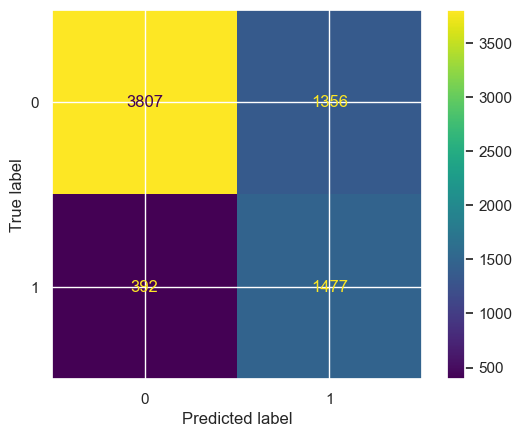

In [16]:
print(classification_report(lr_oof_df["y_true"], lr_oof_df["y_pred"]))
ConfusionMatrixDisplay.from_predictions(lr_oof_df["y_true"], lr_oof_df["y_pred"])


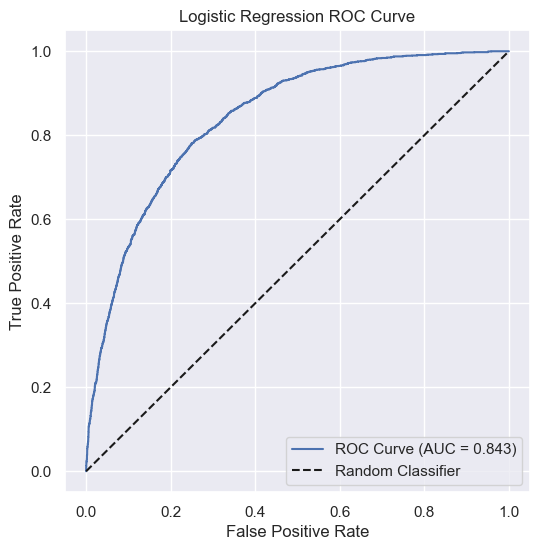

In [17]:
plt.figure(figsize=(6,6))

lr_fpr, lr_tpr, thresholds = roc_curve(lr_oof_df["y_true"], lr_oof_df["y_proba"])
lr_auc = roc_auc_score(lr_oof_df["y_true"], lr_oof_df["y_proba"])

plt.plot(lr_fpr, lr_tpr, label=f"ROC Curve (AUC = {lr_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend()
plt.show()

**Note:** This ROC curve is actually not bad and I could end up using this as my final model. This also suggest a lot of our information is linear which makes sense since some numeric values where directly linked with one another. Such as total charge and tenure. This model will be used later for our feature importance and serves as a good white-box where we can look under the hood to see what exactly is going in our model.

---
## Random Forest

While Logistic Regression excels at finding linear boundaries, human behavior is often complex and non-linear. To capture this, I implemented a Random Forest model. I selected this algorithm because it combines multiple decision tress into a 'forest' of trees.

Unlike a single Decision Tree, which tends to memorize the training data (overfitting), a Random Forest builds hundreds of independent trees. It uses a technique called Bagging (Bootstrap Aggregation), where each tree learns from a random subset of the data and features.

The Mechanism: Each individual tree makes its own prediction (e.g., Tree 1 says 'Churn', Tree 2 says 'Retain').

The Verdict: The Forest aggregates these predictions through a Majority Vote (for classification) or by averaging the probabilities.

By asking hundreds of 'weak' models for their opinion, the Forest cancels out individual errors and produces a 'wisdom of the crowds' prediction that is far more stable than any single tree could achieve."

In [18]:
# This takes about 25 minutes
rf_params = {
    "criterion": ["gini", "entropy", "log_loss"],
    'n_estimators': [300,400],
    'max_depth': [2, 5, 10, 20, None],     # Limit depth to prevent overfitting
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'min_samples_split': [2, 5, 10], # Force trees to be more general
    'class_weight': ['balanced', 'balanced_subsample']
}
rf = RandomForestClassifier(random_state=42)
rf_result = grid_cv(X, y, rf, paramgrid=rf_params, cv=10)



**Note:** I actually had a lot of trouble getting a good model to come out of this especially since the wait time was longer. I was able to finally get a good model once I added the max_features.

In [19]:
print("Best Random Forest F1 Macro:", rf_result['best_f1_macro'])
print("Best Parameters:", rf_result['best_params'])

Best Random Forest F1 Macro: 0.7377912470648774
Best Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 400}


In [20]:
rf = RandomForestClassifier(random_state=42,criterion="entropy", n_jobs=-1, class_weight='balanced_subsample', max_depth=10, min_samples_split = 2,n_estimators=400 , max_features = 0.5)
rf_oof_df, rf_metric_df= kfold_cv( rf, X, y, cv=10, random_state = 42)

In [ ]:
joblib.dump(rf, "best_random_forest_model.pkl")

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      5163
           1       0.57      0.72      0.63      1869

    accuracy                           0.78      7032
   macro avg       0.73      0.76      0.74      7032
weighted avg       0.80      0.78      0.79      7032



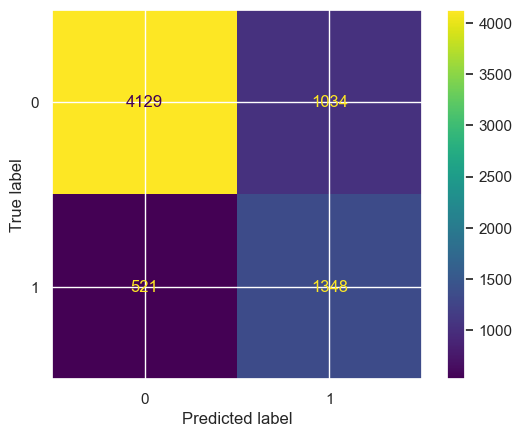

In [21]:
print(classification_report(rf_oof_df["y_true"], rf_oof_df["y_pred"]))
ConfusionMatrixDisplay.from_predictions(rf_oof_df["y_true"], rf_oof_df["y_pred"])

**Note:** Comparing this classification matrix to our Logistic Regression classification matrix we see that Random Forest has more False Negatives but less False Positives. This means our Random Forest model is more conservative. When it detects a customer wants to leave it is more likely that its true compared to logistic regression. This makes it more precise in determining churning customers however, could lead to it missing people because it was not sure enough. In this scenario and in the context of my note earlier if we want to minimize the amount of people we miss(aka they do not even get on the radar that they want to leave) than logistic regression would be better in the scenario. In a real business setting this would depend on the cost of intervention versus the cost of churn.

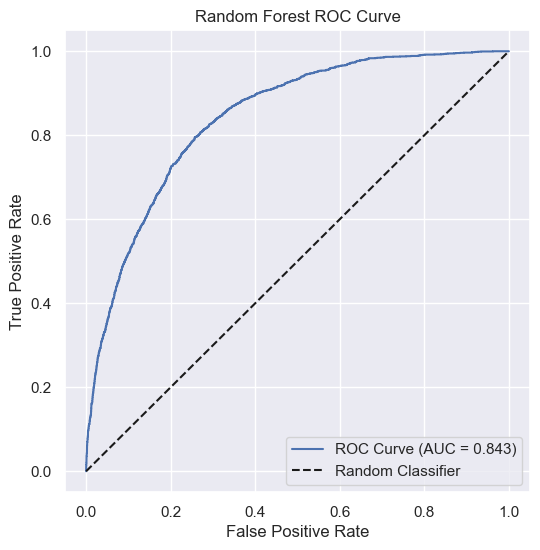

In [22]:
plt.figure(figsize=(6,6))

rf_fpr, rf_tpr, thresholds = roc_curve(rf_oof_df["y_true"], rf_oof_df["y_proba"])
rf_auc = roc_auc_score(rf_oof_df["y_true"], rf_oof_df["y_proba"])

plt.plot(rf_fpr, rf_tpr, label=f"ROC Curve (AUC = {rf_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.show()

1**Note:** This ROC curve is good and matches the other model which was unexpected because I expected Random Forest to outperform logistic regression. This means our classification line is a lot more linear that expected. Which looking back at it makes sense since a lot of what we saw such as tenure and total-charge was a linear relationship. We can even expand this to something like Having services and Monthly charge is also a linear relationship.

---
## Neural Nets

Finally, to capture the most intricate and non-linear patterns in the data, I deployed a Neural Network (specifically a Multi-Layer Perceptron). While the previous models rely on statistical distributions or fixed decision rules, a Neural Network is designed to mimic the structure of the biological brain to learn relationships that are too complex for traditional algorithms.</br>
Generally how this works: </br>
Neural Net combines inputs in the "Hidden Layers" to create new features (e.g., it might figure out on its own that High Charges + Low Tenure = Bad without you telling it).</br>
The model learns by making a guess, checking how wrong it was (Loss), and slightly turning all the knobs (Weights) backward to fix the error. This is called Backpropagation.

In [23]:
def create_keras_model(input_dim, num_hidden, activation , optimizer = "adam" ):
    inputs = Input(shape=(input_dim,))
    layer = layers.Dense(num_hidden, activation=activation)(inputs)
    outputs = layers.Dense(1, activation="sigmoid")(layer)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


**Note:** This is a wrapper function that creates the model instance, adds the layers, sets the appropriate activation function where we can then create it and make it behave like any other of our scikit-learn classifiers.

In [24]:
nn_paramgrid = {"model__activation" : ["relu", "tanh"],
              "model__num_hidden" :[16,32,64],
              "batch_size": [16,32,64],
              "epochs" : [10,20,50],
                "model__optimizer": ["adam", "sgd"]}

nn = KerasClassifier(verbose = 0, model = create_keras_model, input_dim=X.shape[1])




In [25]:
# This line takes about 40 min
nn_result = grid_cv(X, y, nn, paramgrid=nn_paramgrid, cv=10 , n_jobs= 1)

In [ ]:
print("Best Neural Net Score:", nn_result['best_f1_macro'])
print("Best Parameters:", nn_result['best_params'])


Best Neural Net Score: 0.7365034091094979
Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__activation': 'tanh', 'model__num_hidden': 16, 'model__optimizer': 'adam'}


In [ ]:
nn = KerasClassifier(loss= "binary_crossentropy", verbose = 0, model = create_keras_model, optimizer= "adam",batch_size=32, epochs=10, activation="tanh",num_hidden=16, input_dim=X.shape[1])
nn_oof_df, nn_metric_df= kfold_cv( nn, X, y, cv=10, random_state = 42)

In [ ]:
joblib.dump(nn, "best_nn_model.pkl")

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      5163
           1       0.66      0.54      0.60      1869

    accuracy                           0.80      7032
   macro avg       0.75      0.72      0.73      7032
weighted avg       0.80      0.80      0.80      7032



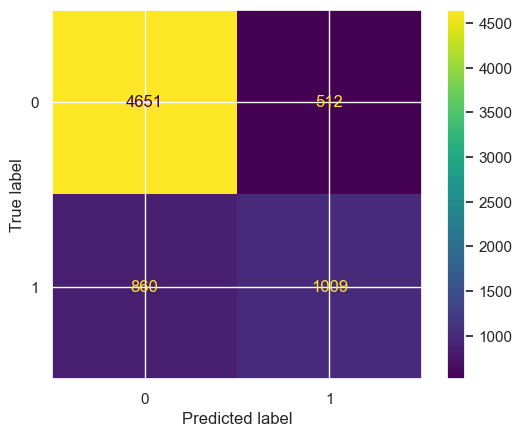

In [ ]:
print(classification_report(nn_oof_df["y_true"], nn_oof_df["y_pred"]))
ConfusionMatrixDisplay.from_predictions(nn_oof_df["y_true"], nn_oof_df["y_pred"])

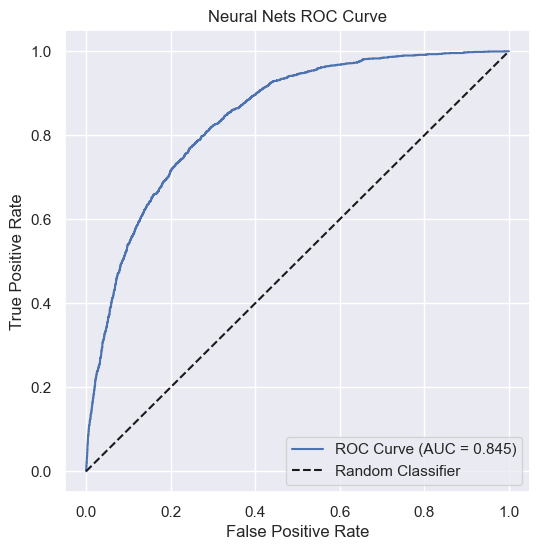

In [ ]:
plt.figure(figsize=(6,6))

(nn_fpr, nn_tpr, thresholds) = roc_curve(nn_oof_df["y_true"], nn_oof_df["y_proba"])
nn_auc = roc_auc_score(nn_oof_df["y_true"], nn_oof_df["y_proba"])

plt.plot(nn_fpr, nn_tpr, label=f"ROC Curve (AUC = {nn_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Nets ROC Curve")
plt.legend()
plt.show()

---
# Model Comparison

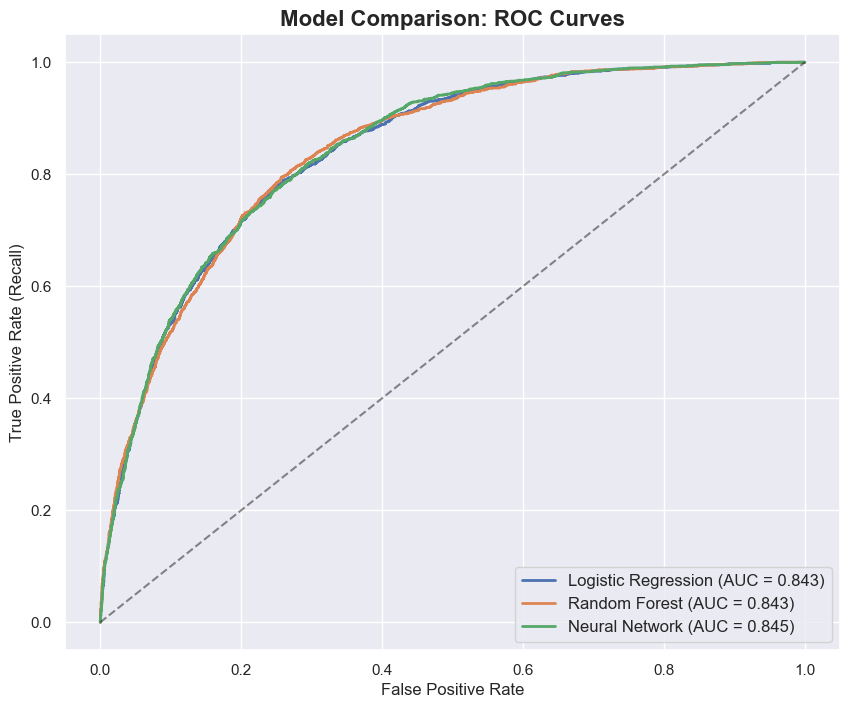

In [ ]:
plt.figure(figsize=(10, 8))

#  Plot Logistic Regression
lr_fpr, lr_tpr, thresholds = roc_curve(lr_oof_df["y_true"], lr_oof_df["y_proba"])
lr_auc = roc_auc_score(lr_oof_df["y_true"], lr_oof_df["y_proba"])
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.3f})", linewidth=2)

# Plot Random Forest
rf_fpr, rf_tpr, thresholds = roc_curve(rf_oof_df["y_true"], rf_oof_df["y_proba"])
rf_auc = roc_auc_score(rf_oof_df["y_true"], rf_oof_df["y_proba"])
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.3f})", linewidth=2)

#  Plot Neural Network
nn_fpr, nn_tpr, thresholds = roc_curve(nn_oof_df["y_true"], nn_oof_df["y_proba"])
nn_auc = roc_auc_score(nn_oof_df["y_true"], nn_oof_df["y_proba"])
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC = {nn_auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate (Recall)", fontsize=12)
plt.title("Model Comparison: ROC Curves", fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.show()

**Note:** The ROC curves for Logistic Regression, Random Forest, and our Neural Network are nearly identical, indicating that each model is extracting the same underlying structure from the data. This suggests performance convergence: the limiting factor is not the choice of algorithm but the information available in the dataset. I believe we need more human behavior information allowing us to predict that human behavior.

In [ ]:
model_metrics = [
    lr_metric_df.drop('fold', axis=1).mean(numeric_only=True),
    rf_metric_df.drop('fold', axis=1).mean(numeric_only=True),
    nn_metric_df.drop('fold', axis=1).mean(numeric_only=True),
]

df_mean_metrics = pd.DataFrame(model_metrics)

df_mean_metrics.index = ["Logistic Regression", "Random Forest", "Neural Network"]


In [ ]:
print("Mean Model Metrics:")
print(df_mean_metrics)


Mean Model Metrics:
                     accuracy  precision    recall        f1
Logistic Regression  0.751421   0.521622  0.790265  0.628151
Random Forest        0.778867   0.565842  0.721235  0.634040
Neural Network       0.804891   0.665244  0.539860  0.595018


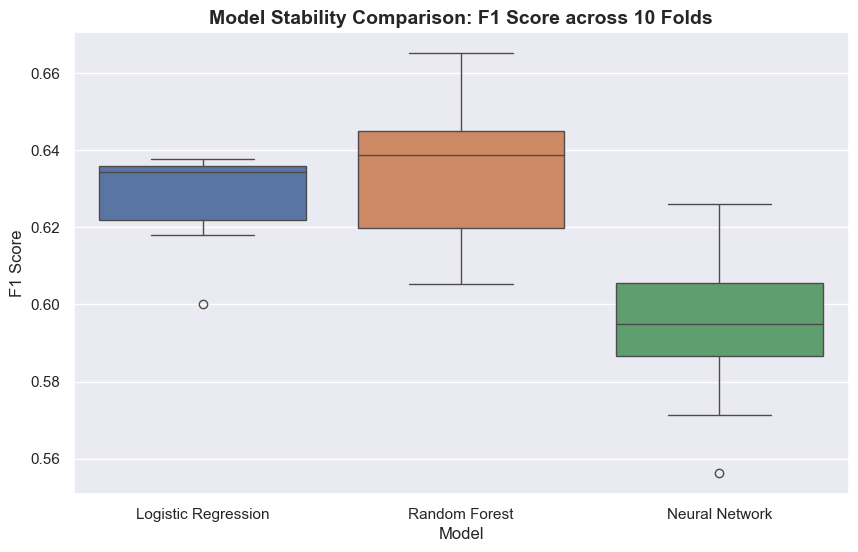

In [ ]:
lr_metric_df['Model'] = "Logistic Regression"
rf_metric_df['Model'] = "Random Forest"
nn_metric_df['Model'] = "Neural Network"

all_metrics = pd.concat([lr_metric_df, rf_metric_df, nn_metric_df])

plt.figure(figsize=(10, 6))
sns.violinplot(data=all_metrics, x='Model', y='f1', inner = "box")
plt.title("Model Stability Comparison: F1 Score across 10 Folds", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score")
plt.show()

**Note:** Model stability was evaluated by measuring the distribution of F1 scores across 10 cross-validation folds. **Violin Plot** show both the median performance and variability. A narrower interquartile range (IQR) indicates a more stable model.

From the comparison we can see that our most stable model is the logistic regression with one slight outlier. While the Random Forest is able to get the best median performance, compared to Logistic Regression is not by much. We also see a high range with our Random Forest Model. Even though it does has the best over all performance it seems to have high variance between folds.


---
# Model Choice

The Final Model Chosen was the Logistic Regression Model

In [ ]:
coefficients = lr.coef_[0]

feature_names = X.columns.copy()

df_coef = pd.DataFrame({"feature": feature_names, "coefficient": coefficients})
df_coef["Abs_Coef"] = df_coef["coefficient"].abs()
df_coef["Odds_ration"] = np.exp(df_coef["coefficient"])
df_coef.sort_values(by=["Abs_Coef"], ascending=False, inplace=True)


df_coef.head(10)

,feature,coefficient,Abs_Coef,Odds_ration
0,numeric__tenure,-0.680908,0.680908,0.506157
37,categorical__Contract_Month-to-month,0.496882,0.496882,1.643589
39,categorical__Contract_Two year,-0.424486,0.424486,0.654106
17,categorical__InternetService_Fiber optic,0.306972,0.306972,1.359303
44,categorical__PaymentMethod_Electronic check,0.271645,0.271645,1.312121
1,numeric__MonthlyCharges,0.250442,0.250442,1.284593
16,categorical__InternetService_DSL,-0.241011,0.241011,0.785833
28,categorical__TechSupport_No,0.225767,0.225767,1.253284
19,categorical__OnlineSecurity_No,0.216807,0.216807,1.242105
30,categorical__TechSupport_Yes,-0.159806,0.159806,0.852309


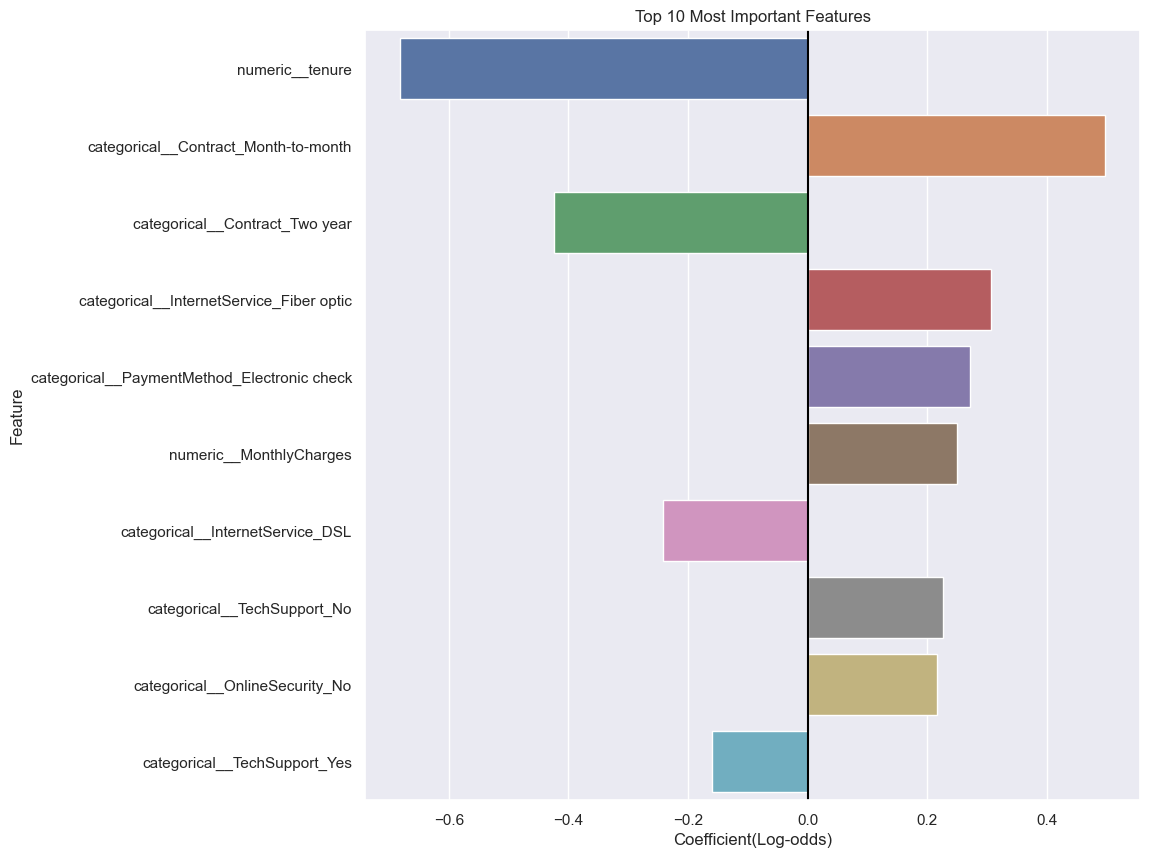

In [ ]:
# ANSWER:
plt.figure(figsize = (10,10))

ax = sns.barplot(data= df_coef.head(10), x= "coefficient", y= "feature", hue = "feature", legend = False )

ax.set_title("Top 10 Most Important Features")
ax.set_xlabel("Coefficient(Log-odds)")
ax.set_ylabel("Feature")
ax.axvline(0, color="black")

plt.show()